## Preparation

Make sure that your Colab Notebook has access to a GPU!

In [1]:
# install required libraries via pip

!pip install diffusers==0.11.1
!pip install transformers scipy ftfy accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# import libraries

import gensim.downloader
import os
import torch
import numpy as np

from diffusers import StableDiffusionPipeline
from PIL import Image
from scipy.spatial.distance import cosine
from transformers import BlipProcessor, BlipForConditionalGeneration

In [3]:
# create folders if they don't exist already

folder_names = ['embeddings', 'images']

# check and create folders if they don't exist
for folder_name in folder_names:
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
        print(f"Folder '{folder_name}' created.")
    else:
        print(f"Folder '{folder_name}' already exists.")

Folder 'embeddings' already exists.
Folder 'images' already exists.


## Stable Diffusion (Text to Image)

In [4]:
pipe = StableDiffusionPipeline.from_pretrained('CompVis/stable-diffusion-v1-4', torch_dtype=torch.float16)
pipe = pipe.to('cuda')

Fetching 20 files:   0%|          | 0/20 [00:00<?, ?it/s]

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

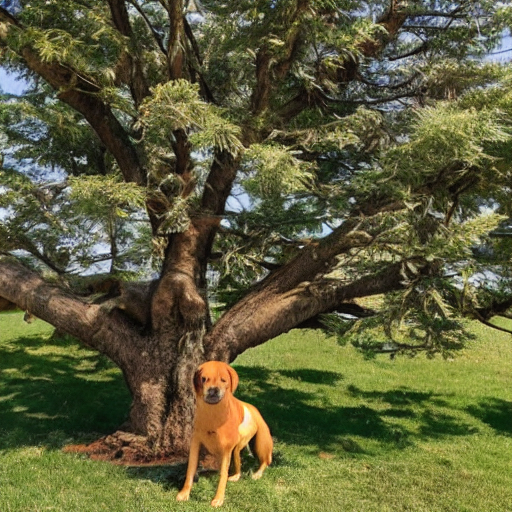

In [5]:
initial_caption = 'a dog and a tree'
image1 = pipe(initial_caption).images[0]

image1.save('images/image1.png')

image1.show()

## Blip (Image to text)

In [6]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base", torch_dtype=torch.float16).to("cuda")
 
raw_image = Image.open('images/image1.png').convert('RGB')


In [7]:
inputs = processor(raw_image, return_tensors="pt").to("cuda", torch.float16)

out = model.generate(**inputs)
image1_caption = processor.decode(out[0], skip_special_tokens=True)
print(image1_caption)

a dog sitting under a tree in the grass


## Comparison

In [8]:
# Download Google News Word Embedding. If it's downloaded already it won't do it again!

embedding_path = 'embeddings/word2vec-google-news-300.bin'
embedding_name = 'word2vec-google-news-300'

if os.path.exists(embedding_path):
    print("Word Embedding has been downloaded already.")
else:
  google_news_embedding = gensim.downloader.load(embedding_name)
  google_news_embedding.save(embedding_path)


Word Embedding has been downloaded already.


In [9]:
google_news_word_embedding = gensim.models.KeyedVectors.load(embedding_path)

def get_mean_vector(sentence, word_embedding):
  tokens = sentence.split()
  embedding = [word_embedding[word] for word in tokens if word in word_embedding]

  if len(embedding) > 0:
    return np.mean(embedding, axis=0)
  else:
    return None

initial_caption_mv = get_mean_vector(initial_caption, google_news_word_embedding)
image1_caption_mv = get_mean_vector(image1_caption, google_news_word_embedding)

## Results


Initial Caption: a dog and a tree

Image 1:


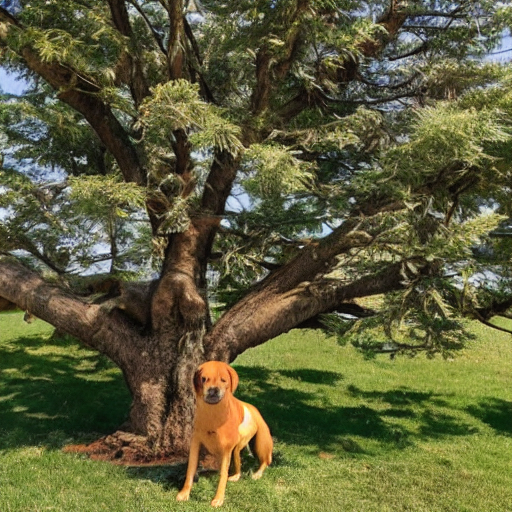


Image 1 Caption: a dog sitting under a tree in the grass


Similarity between the sentences: 0.7713097929954529


In [14]:
def calculate_mv_similarity(sentence_1_mv, sentence_2_mv):
  if sentence_1_mv is not None and sentence_2_mv is not None:
    similarity = 1 - cosine(sentence_1_mv, sentence_2_mv)
    print('\nSimilarity between the sentences:', similarity)
  else:
    print('\nOne or both sentence embeddings could not be calculated.')


print(f'\nInitial Caption: {initial_caption}\n')
print(f'Image 1:')
image1.show()
print(f'\nImage 1 Caption: {image1_caption}\n')
calculate_mv_similarity(initial_caption_mv, image1_caption_mv)

## Discussion and improvements

**Disclaimer:** Since generativ AI is involved your results might change if you rerun the notebook for yourself. However, the general results should stay similar, especially if you use more detailled prompts. The dog and tree example is rather general and unspecific. (For example the color of the dog might change or ihis position).

### Possible Improvements:

1. Improve prompt details
2. Use conditional formatting for BLIP
3. Finetune the Stable Diffusion model
4. Use a different word embedding
5. A combination of the Methods above


##Detailed Prompts

Let's try it. Maybe we can get a better performance if we add more details to our prompt.

But first let's create a function, so we can properly use the things and avoid duplicate code as much as possible.

In [11]:
def run_pipeline(initial_caption, word_embedding):
  # generate image
  image1 = pipe(initial_caption).images[0]
  image1.save('images/image1.png')

  # generate caption from image
  raw_image = Image.open('images/image1.png').convert('RGB')
  inputs = processor(raw_image, return_tensors="pt").to("cuda", torch.float16)
  out = model.generate(**inputs)
  image1_caption = processor.decode(out[0], skip_special_tokens=True)

  # compare captions
  initial_caption_mv = get_mean_vector(initial_caption, word_embedding)
  image1_caption_mv = get_mean_vector(image1_caption, word_embedding)

  # print results
  print(f'\nInitial Caption: {initial_caption}\n')
  print(f'Image 1:')
  image1.show()
  print(f'\nImage 1 Caption: {image1_caption}\n')
  calculate_mv_similarity(initial_caption_mv, image1_caption_mv)

  0%|          | 0/50 [00:00<?, ?it/s]


Initial Caption: a golden retriever sits in front of an oak

Image 1:


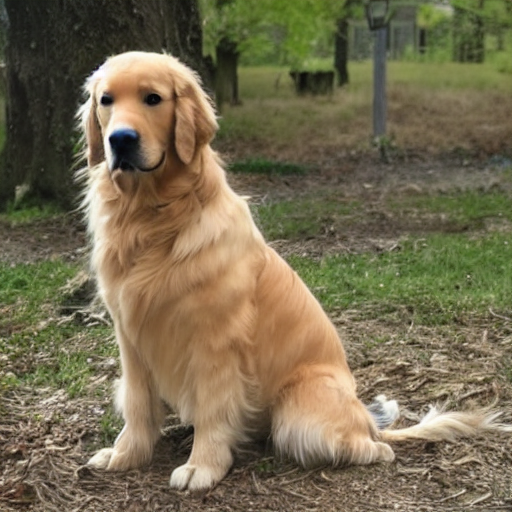


Image 1 Caption: a golden retrieve dog sitting in the grass


Similarity between the sentences: 0.6659154891967773


In [15]:
run_pipeline('a golden retriever sits in front of an oak', google_news_word_embedding)

  0%|          | 0/50 [00:00<?, ?it/s]


Initial Caption: a dog laying on the grass in the yard

Image 1:


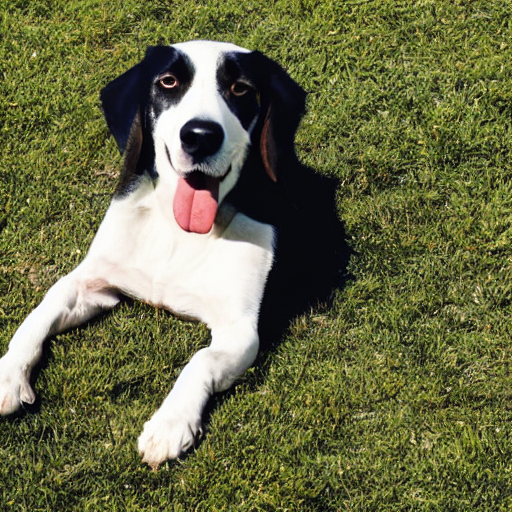


Image 1 Caption: a dog laying on the grass


Similarity between the sentences: 0.9162070155143738


In [16]:
run_pipeline('a dog laying on the grass in the yard', google_news_word_embedding)